Autor: Pablo Veloz

In [1]:
pip install wordcloud

Note: you may need to restart the kernel to use updated packages.


### __Desafío - Inferencia de tópicos con EM__

__Descripción__
- En esta sesión trabajaremos con una serie de base de datos sobre letras musicales de distintos artistas. 
- Cada uno de los csv se encuentra en la carpeta dump .
- Cada csv tiene el nombre del artista a analizar. Los archivos contienen el nombre del artista, el género musical del artista, el nombre de la canción y las letras.
- En base a esta información, el objetivo del ejercicio es generar un modelo probabilístico que pueda identificar el género musical más probable dado la letra de una canción.
- Para ello implementaremos un modelo conocido como Latent Dirichlet Allocation que hace uso de una variante del algoritmo EM para inferir clases latentes a partir de una matriz de documentos.

__Ejercicio 1: Preparar el ambiente de trabajo__
- Importe los módulos numpy , pandas , matplotlib , seaborn , glob y os siguiendo las buenas prácticas. 
- Los últimos dos módulos permitirán realizar la importación de múltiples archivos dentro de la carpeta dump .
- Para ello genere un objeto que guarde en una lista todos los archivos alojados en dump utilizando glob.glob y os.getcwd() para extraer las rutas absolutas. 
- Posteriormente genere un objeto pd.DataFrame que contenga todos los csv.
- Asegúrese de eliminar la columna Unnamed: 0 que se genera por defecto.

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings(action='ignore')
import seaborn as sns
import os
import glob
import aux_funciones as auxiliares

In [3]:
dataframes = list(map(lambda path: pd.read_csv(os.getcwd() + '/' + path), glob.glob('Archivos para desafío/dump/*')))
df = pd.concat(dataframes).drop(columns=['Unnamed: 0'])
df.columns = ['artist', 'genre', 'song', 'lyrics']
df.head()

,artist,genre,song,lyrics
0,Bruce Springsteen,rock,Blinded By The Light,Madman drummers bummers and Indians in the sum...
1,Bruce Springsteen,rock,Growin' Up,Well I stood stone-like at midnight \n Suspend...
2,Bruce Springsteen,rock,Mary Queen Of Arkansas,"Mary Queen of Arkansas, it's not too early for..."
3,Bruce Springsteen,rock,Does This Bus Stop At 82nd Street?,"Hey bus driver, keep the change \n Bless your ..."
4,Bruce Springsteen,rock,Lost In The Flood,The ragamuffin gunner is returnin' home like a...


__Ejercicio 2: Matriz de ocurrencias__
- Importe la clase CountVectorizer dentro de los módulos feature_extraction.text de la librería sklearn .
- Aplique la clase para extraer las 5000 palabras más repetidas en toda la base de datos.
- Con la clase inicializada, incorpore las letras con el método fit_transform y guarde los resultados en un nuevo objeto

In [4]:
from sklearn.feature_extraction.text import CountVectorizer
# instanciamos un objeto
count_vectorizer=CountVectorizer(stop_words='english',max_df=.1,max_features=5000)
# Implementamos los pasos fit y transform
count_vectorizer_fit = count_vectorizer.fit_transform(df['lyrics'])
# Extraemos tokens (palabras)
words = count_vectorizer.get_feature_names()
# extraemos frecuencia
words_freq2= count_vectorizer_fit.toarray()
words_freq = count_vectorizer_fit.toarray().sum(axis=0)

In [5]:
count_vectorizer_fit.shape

(9489, 5000)

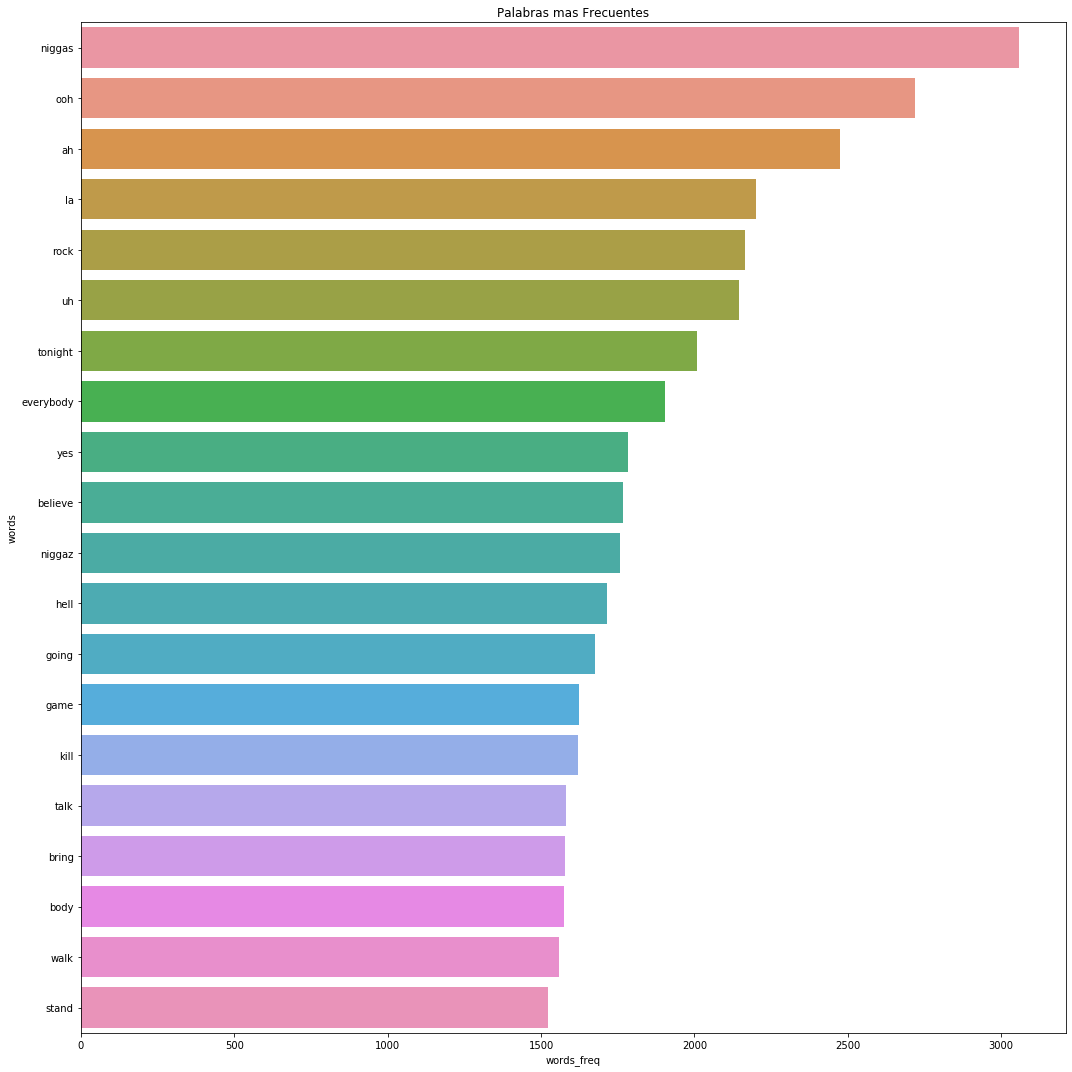

In [6]:
df2=pd.DataFrame(zip(words,words_freq),columns=["words","words_freq"])
df2=df2.sort_values(by=["words_freq"],ascending=False)
df3=df2.head(20)
plt.figure(figsize=(15, 15))
sns.barplot(y=df3['words'],x=df3['words_freq'])
plt.title('Palabras mas Frecuentes')
plt.tight_layout()

__Ejercicio 3: Entrenamiento del Modelo__
- Importe sklearn.decomposition.LatentDirichletAllocation sklearn.model_selection.GridSearchCV .
- Genere una búsqueda de grilla con los siguientes hiperparámetros:
    - n_components: [5, 10, 15] .
    - learning_decay: [0.7, 0.5] .
- Entrene la búsqueda de grilla con las letras en un formato vectorizado con CountVectorizer .
- Reporte brevemente cuál es la mejor combinación de hiperparámetros.

__Digresión: Latent Dirichlet Allocation__
- Latent Dirichlet Allocatio (LDA) es un modelo probabilístico generativo basado en Inferencia Variacional EM. 
- La principal utilidad de éste es la identificación de tópicos en un corpus de texto. El proceso de inferencia se puede resumir en los siguientes pasos:
    - Cada documento dentro del corpus se puede entender como una mezcla de tópicos comunes a nivel de corpus.
    - Esta mezcla de tópicos es latente $\leadsto$ Sólo observamos los documentos registrados y sus palabras. 
- La API de sklearn.decomposition.LatentDirichletAllocation presenta la misma funcionalidad de todo modelo de sklearn. Algunos puntos a considerar en la inicialización de la clase son:
    - n_components : Cantidad de tópicos a inferir en un corpus.
    - learning_method : Forma en la que entran los datos en entrenamiento. Cuando es 'batch' , se ingresa la matriz de entrenamiento completa. Cuando es 'online' , la matriz de entrenamiento ingresa de manera secuencial en parcelas pequeñas.
    - learning_decay : Tasa de aprendizaje en la función de pérdida. Cuando se implementa con learning_method='online' , el modelo se entrena con Gradiente Estocástico Descendente.
    - Perplejidad: Busca aproximar el número óptimo de tópicos a inferir. Técnicamente evalúa qué tan bien predice una muestra específica. En funcieon a un número de tópicos, define la distribución teórica de palabras representada por los tópicos y la compara con la ocurrencia empírica de palabras en tópicos.

- Importe sklearn.decomposition.LatentDirichletAllocation sklearn.model_selection.GridSearchCV .

In [42]:
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.model_selection import GridSearchCV

In [31]:
params = {'n_components': [5, 10, 15],'learning_decay': [0.7, 0.5]}
em_params = GridSearchCV(LatentDirichletAllocation(learning_method='online'), params, cv=5,n_jobs=-1)

In [32]:
report = em_params.fit(count_vectorizer_fit)

In [33]:
best_learning_decay = report.best_params_['learning_decay']
best_n_components = report.best_params_['n_components']
print('La mejor combinación de hiperparámetros es learning_decay = {} y n_components = {}'.format(best_learning_decay, best_n_components))

La mejor combinación de hiperparámetros es learning_decay = 0.5 y n_components = 5


In [7]:
from joblib import dump, load
best_lda_model=load("Latent_dirichlet_alloc.joblib")

In [8]:
best_lda_model.get_params

<bound method BaseEstimator.get_params of LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
                          evaluate_every=-1, learning_decay=0.7,
                          learning_method='online', learning_offset=10.0,
                          max_doc_update_iter=100, max_iter=10,
                          mean_change_tol=0.001, n_components=5, n_jobs=None,
                          perp_tol=0.1, random_state=None,
                          topic_word_prior=None, total_samples=1000000.0,
                          verbose=0)>

__Ejercicio 4 : Inferencia e Identificación de Tópicos__
- En base a la mejor combinación de hiperparámetros, entrene el modelo con la matriz de atributos de las letras.
- Para identificar de qué se trata cada tópico, necesitamos identificar las principales 15 palabras asociadas con éste. Puede implementar la siguiente línea de código para identificar las principales palabras en un tópico:
- Comente a qué tópicos está asociada cada clase inferida.

In [9]:
for topic_id, topic_name in enumerate(best_lda_model.components_):
    print("topico: {}".format(topic_id+1))
    print(" ".join([count_vectorizer.get_feature_names()[i] for i in topic_name.argsort()[:-15-1:-1]]))

topico: 1
rock roll uh beat mos def everybody yes hands whoa party ready jump ha mon
topico: 2
niggas niggaz ma fuckin gon rap bitches game da uh dre bout wit verse eminem
topico: 3
didn talk friends everybody wrong dance mama maybe work somebody going crazy took friend went
topico: 4
ooh ah la tonight ba na believe moment boom body bring yes future babe save
topico: 5
sun pain fall hell sky dream forever coming lost rain kill war cold free dark


__Ejercicio 5: Identificación de probabilidades__
- En base a la información generada, es posible identificar cuales van a ser los géneros más probables de ocurrir para un artista.
- Para ello necesitamos guardar la probabilidad de cada canción en nuestra base de datos original. Podemos implementar esto de la siguiente manera:

In [10]:
fit_best_lda = best_lda_model.transform(count_vectorizer_fit)
# estra transformación la podemos coercionar a un dataframe de la siguiente manera
topics_for_each_doc = pd.DataFrame(np.round(fit_best_lda, 3),index=df.index)
# pasamos esta matriz y la redondeamos en 3 decimales
# agregamos un índice
#agregamos identificadores de columna
topics_for_each_doc.columns = list(map(lambda x: "T: {}".format(x), range(1,best_lda_model.n_components + 1)))
# concatenamos las probabilidades de tópico por documento a nuestra matriz original
concatenated_df = pd.concat([df, topics_for_each_doc], axis=1)# argmax en la matriz de tópicos
concatenated_df['highest_topic'] = np.argmax(topics_for_each_doc.values, axis=1) + 1

In [11]:
concatenated_df.head()

,artist,genre,song,lyrics,T: 1,T: 2,T: 3,T: 4,T: 5,highest_topic
0,Bruce Springsteen,rock,Blinded By The Light,Madman drummers bummers and Indians in the sum...,0.072,0.151,0.468,0.022,0.286,3
1,Bruce Springsteen,rock,Growin' Up,Well I stood stone-like at midnight \n Suspend...,0.003,0.003,0.537,0.176,0.282,3
2,Bruce Springsteen,rock,Mary Queen Of Arkansas,"Mary Queen of Arkansas, it's not too early for...",0.003,0.003,0.319,0.078,0.597,5
3,Bruce Springsteen,rock,Does This Bus Stop At 82nd Street?,"Hey bus driver, keep the change \n Bless your ...",0.003,0.326,0.366,0.003,0.302,3
4,Bruce Springsteen,rock,Lost In The Flood,The ragamuffin gunner is returnin' home like a...,0.167,0.239,0.112,0.001,0.480,5


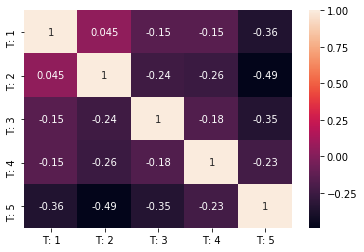

In [12]:
sns.heatmap(concatenated_df.loc[:, 'T: 1':'T: 5'].corr(), annot=True);

In [13]:
artist = 'Bruce Springsteen'
BruceSpringsteen = concatenated_df[concatenated_df['artist'] == artist]

In [14]:
BruceSpringsteen['highest_topic'].value_counts('%')


5    0.498929
3    0.389722
1    0.059957
4    0.036403
2    0.014989
Name: highest_topic, dtype: float64

(-0.5, 1599.5, 1199.5, -0.5)

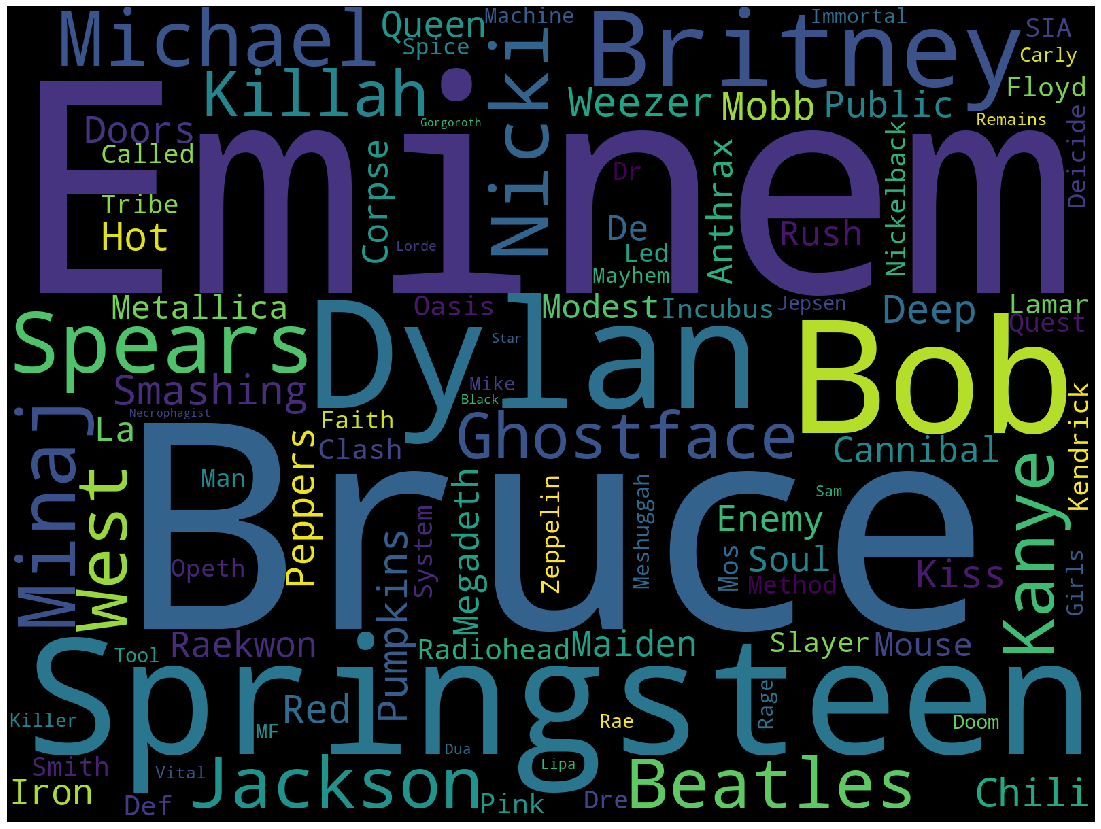

In [25]:
from wordcloud import WordCloud
cloud = WordCloud(width=1600, height=1200, collocations=False).generate(" ".join(df['artist'].astype(str)))
plt.figure(figsize=(20, 15))
plt.imshow(cloud)
plt.axis('off')
